<a href="https://colab.research.google.com/github/foxyreign/AAA_Movie/blob/main/Data_Strategy_Plan_for_AAA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data Strategy Plan for AAA**


---



# Dataset Preparation

Three datasets are downloaded and extracted directly from IMDB live database:

1.   Title Basics - contains the title, year of release and genres. Only movies are selected.
2.   Title Ratings - contains the weighted average rating and number of votes.

Since IMDB database does not have the datasets needed for actor ratings and other analyses, several external public datasets were used to supplement.

Due to RAM restrictions, each of the dataset is extracted one by one and any unnecessary files and variables were deleted after.

In [1]:
# Download gz files
basics = 'https://datasets.imdbws.com/title.basics.tsv.gz'
ratings = 'https://datasets.imdbws.com/title.ratings.tsv.gz'

!wget {basics}
!wget {ratings}

--2024-06-03 07:42:27--  https://datasets.imdbws.com/title.basics.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 99.84.160.48, 99.84.160.41, 99.84.160.94, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|99.84.160.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 189708026 (181M) [binary/octet-stream]
Saving to: ‘title.basics.tsv.gz’

title.basics.tsv.gz 100%[===================>] 180.92M   238MB/s    in 0.8s    

2024-06-03 07:42:28 (238 MB/s) - ‘title.basics.tsv.gz’ saved [189708026/189708026]

--2024-06-03 07:42:28--  https://datasets.imdbws.com/title.ratings.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 99.84.160.48, 99.84.160.41, 99.84.160.94, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|99.84.160.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7252826 (6.9M) [binary/octet-stream]
Saving to: ‘title.ratings.tsv.gz.1’

title.ratings.tsv.g 100%[===================>]   6.92

Basics dataset

In [2]:
import gzip
import pandas as pd
import os

# Set chunk size
chunk_size = 8192

# Extract dataset one by one due to RAM restriction and remove unnecessary files
# basics
with gzip.open('title.basics.tsv.gz', 'rb') as f_in:
  with open('basics.txt', 'wb') as f_out:
    chunk = f_in.read(chunk_size)
    while chunk:
      f_out.write(chunk)
      chunk = f_in.read(chunk_size)

# Load akas dataset
basics_df = pd.read_csv('basics.txt', sep='\t',
                        usecols=['tconst','titleType','primaryTitle','startYear','genres'])

# Remove unnecessary files
os.remove('basics.txt')
os.remove('title.basics.tsv.gz')

# Retain movies only
movies_df = basics_df[basics_df['titleType']=='movie']

# Expand genres column to multiple columns
genres = movies_df['genres'].str.split(',', expand=True)
genres.columns = ['genre_1','genre_2','genre_3']

# Merge movies_df and genres, delete genres dataset
movies_df = pd.merge(movies_df, genres, left_index=True, right_index=True)
del(genres)

# Delete genres column from movies_df
movies_df = movies_df.drop('genres', axis=1)

# Replace \N with null
movies_df['genre_1'] = movies_df['genre_1'].str.replace('\\N', '')
movies_df['genre_2'] = movies_df['genre_2'].str.replace('None', '')
movies_df['genre_3'] = movies_df['genre_3'].str.replace('None', '')

# Create dataset of movies in 2020
movies_2020_df = movies_df[movies_df['startYear']=='2020']

Ratings

In [23]:
import gzip
import pandas as pd
import os

# Set chunk size
chunk_size = 4096

# ratings
with gzip.open('title.ratings.tsv.gz', 'rb') as f_in:
  with open('ratings.txt', 'wb') as f_out:
    chunk = f_in.read(chunk_size)
    while chunk:
      f_out.write(chunk)
      chunk = f_in.read(chunk_size)

# Load basics dataset
ratings_df = pd.read_csv('ratings.txt', sep='\t')

# Merge movies in 2020 and ratings
movies_2020_df = pd.merge(movies_2020_df, ratings_df, how='left',
                          left_index=True, right_index=True)

# Remove unnecessary files
#os.remove('ratings.txt')
#os.remove('title.ratings.tsv.gz')

FileNotFoundError: [Errno 2] No such file or directory: 'title.ratings.tsv.gz'

Actors

The actors dataset is saved a public repository on Github.

In [4]:
actors_url = 'https://raw.githubusercontent.com/foxyreign/AAA_Movie/main/actorfilms.csv'
actors_df = pd.read_csv(actors_url,sep=',',
                        dtype = {'Actor':str,
                                 'ActorID':str,
                                 'Film':str,
                                 'Year':str,
                                 'Votes':int,
                                 'Rating':float,
                                 'FilmID':str})

Movies

In [5]:
movies_url = 'https://raw.githubusercontent.com/foxyreign/AAA_Movie/main/Movies.csv'
movies2_df = pd.read_csv(movies_url,sep=',')
print(movies2_df.dtypes)

Unnamed: 0               int64
Name of the movie       object
Year of release          int64
Watchtime                int64
Movie Rating           float64
Metascore              float64
Votes                    int64
Gross collection(M)    float64
Rating                 float64
Overview                object
Director                object
Stars                   object
Genre_1                 object
Genre_2                 object
Genre_3                 object
dtype: object


In [6]:
movies2_df.head(2)

,Unnamed: 0,Name of the movie,Year of release,Watchtime,Movie Rating,Metascore,Votes,Gross collection(M),Rating,Overview,Director,Stars,Genre_1,Genre_2,Genre_3
0,0,The Shawshank Redemption,1994,142,9.3,82.0,2784747,28.34,9.3,"Over the course of several years, two convicts...","Frank Darabont, Tim Robbins, Morgan Freeman, B...","Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Drama,NaN,NaN
1,1,The Godfather,1972,175,9.2,100.0,193985,134.97,9.2,"Don Vito Corleone, head of a mafia family, dec...","Francis Ford Coppola, Marlon Brando, Al Pacino...","Marlon Brando, Al Pacino, James Caan, Diane Ke...",Crime,Drama,NaN


# Exploratory Data Analysis

The following interactive plots are available for viewing on:
https://public.tableau.com/app/profile/foxyreign/viz/AAAMovies/Summary

*   Popular Actors of 2020
*   Highest Rated Movies of 2020
*   Trend In-Movie Preferences



**Highest Rated Movie of 2020**

Each movie title is given a weighted average of all the individual user ratings.

In an unbalanced number of votes across different movie titles, a very popular movie could have multiple votes while a niche movie would result to limited number of votes. The latter would be more sensitive to fluctuation of the averages while the former would have stable average value as the law of large numbers would apply.

To balance the ratings with the number of votes, compute the Bayesian rating (which is the weighted rating of movie titles based on number of votes) per distribution grouping of number of votes.

\begin{equation}
WeightedRating = (\frac{votes}{votes+top1000})*rating+(\frac{top1000}{votes+top1000})*rating_{avg}
\end{equation}

For this analysis, only top 10 movies will be selected among the top 1,000 movies.

In [7]:
# Compute weighted rating
top = 1000 # Set top 1000 movies
movies_2020_df['wr'] = (movies_2020_df['numVotes']/(movies_2020_df['numVotes']+top))*movies_2020_df['averageRating']+(top/(movies_2020_df['numVotes']+top))*movies_2020_df['averageRating'].mean()
movies_2020_df['wr'] = movies_2020_df['wr'].round(2)

In [8]:
# Check dataset after wr calculation
movies_2020_df

# Export to CSV
movies_2020_df.to_csv('movies_2020_df.csv')

[Text(0, 0, '9.04'),
 Text(0, 0, '9.01'),
 Text(0, 0, '8.88'),
 Text(0, 0, '8.7'),
 Text(0, 0, '8.68'),
 Text(0, 0, '8.56'),
 Text(0, 0, '8.53'),
 Text(0, 0, '8.49'),
 Text(0, 0, '8.49'),
 Text(0, 0, '8.41')]

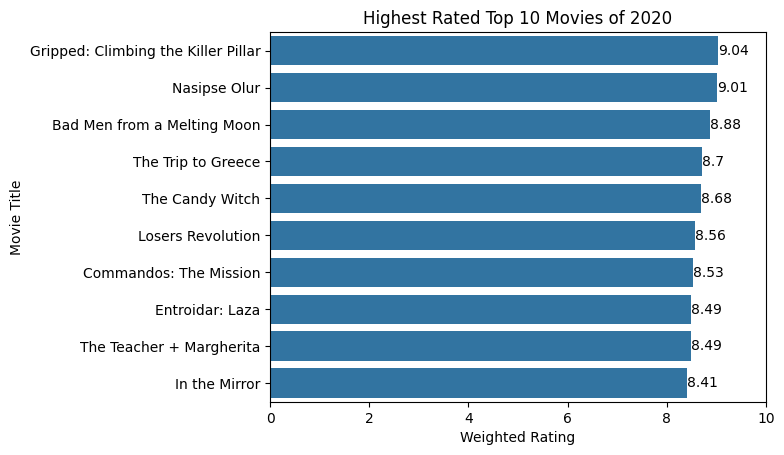

In [9]:
# Top 10 movies base on weighted rating
import seaborn as sns
import numpy as np

# Create barplot
top10_movies = sns.barplot(y='primaryTitle',x='wr',
                            data=movies_2020_df.nlargest(10,'wr'))

# Set figure options
top10_movies.set(xlabel='Weighted Rating',ylabel='Movie Title',
                 title='Highest Rated Top 10 Movies of 2020',
                 xlim=(0,10))

# Add weighted rating labels
top10_movies.bar_label(top10_movies.containers[0])

**Most Popular Actor in 2020**

Actor popularity is calculated based on the number of votes regardless of their rating.

In [10]:
# Create dataset of actors where movies were released in 2020.
actors_2020_df = actors_df[(actors_df['Year']=='2020')]

# Create dataset based on average rating of actors
actors_2020_votes = actors_2020_df[['Actor', 'Votes']].copy()
actors_2020_votes_df = actors_2020_df.groupby(['Actor','ActorID','Year']).sum()
actors_2020_votes_df

# Export to CSV
actors_2020_votes_df.to_csv('actors_2020_votes_df.csv')

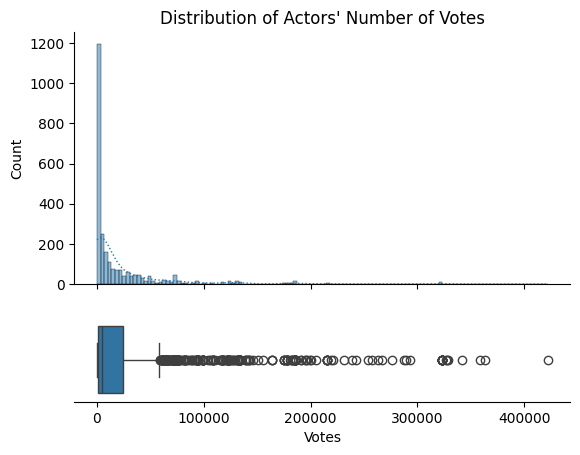

In [11]:
# Plot histogram of votes
import matplotlib.pyplot as plt

f, (ax_hist, ax_box) = plt.subplots(2, sharex=True,
                                    gridspec_kw={"height_ratios": (.75, .25)})

sns.histplot(x=actors_2020_votes_df['Votes'], kde=True, ax=ax_hist,
             line_kws={'color':'crimson','lw':1,'ls':':'})
sns.boxplot(x=actors_2020_votes_df['Votes'], ax=ax_box)

ax_box.set(yticks=[])
ax_hist.set_title("Distribution of Actors' Number of Votes")
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

<ipython-input-12-7475528b9834>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  top10_actors.set_xticklabels(xlabels)


[Text(0.0, 0, '0.00K'),
 Text(50000.0, 0, '50.00K'),
 Text(100000.0, 0, '100.00K'),
 Text(150000.0, 0, '150.00K'),
 Text(200000.0, 0, '200.00K'),
 Text(250000.0, 0, '250.00K'),
 Text(300000.0, 0, '300.00K'),
 Text(350000.0, 0, '350.00K'),
 Text(400000.0, 0, '400.00K'),
 Text(450000.0, 0, '450.00K')]

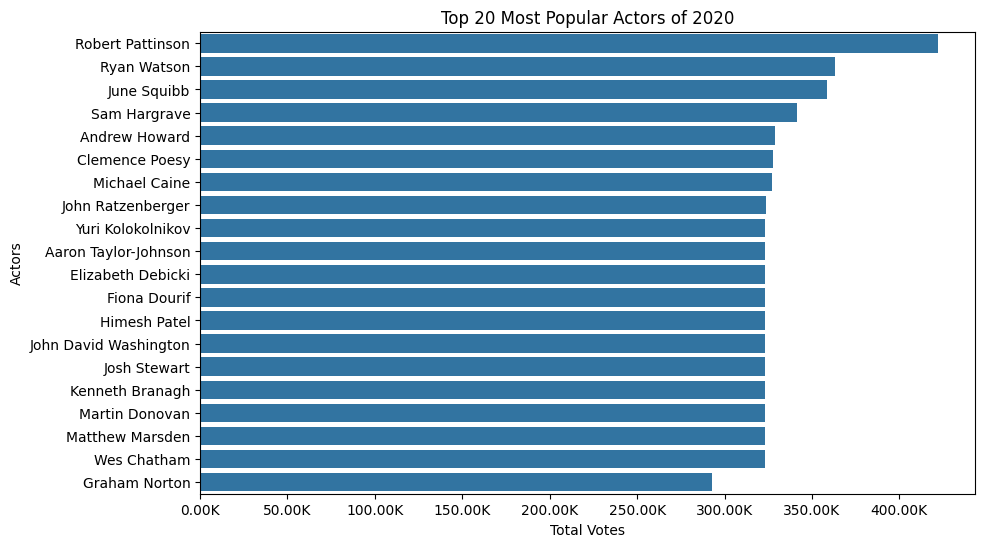

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

# Create barplot
top10_actors = sns.barplot(x='Votes',y='Actor', ax=ax,
                            data=actors_2020_votes_df.nlargest(20,'Votes'))

# Set figure options
top10_actors.set(xlabel='Total Votes',ylabel='Actors',
                 title='Top 20 Most Popular Actors of 2020',)
xlabels = ['{:,.2f}'.format(x) + 'K' for x in top10_actors.get_xticks()/1000]
top10_actors.set_xticklabels(xlabels)

**Trends in user-movie preferences**

As the popularity of movies are based on number of votes, it is found that it is moderately correlated with the gross collections, p-value < 0.01.

<Axes: >

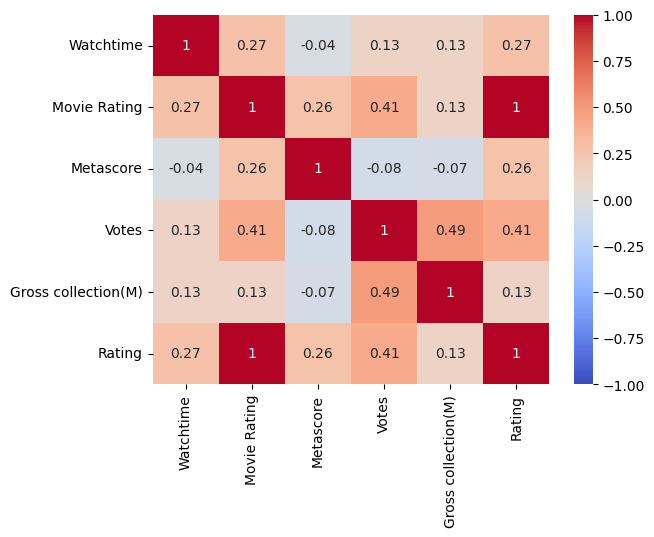

In [13]:
import scipy.stats as stats

# Compute for correlation matrix
movies_corr_df = movies2_df[['Watchtime',
                             'Movie Rating',
                             'Metascore',
                             'Votes',
                             'Gross collection(M)',
                             'Rating']].copy()

movies_corr_values = round(movies_corr_df.corr(),2)

# Plot correlation matrix
sns.heatmap(movies_corr_values,
            cmap='coolwarm',
            vmin=-1,vmax=1,
            annot=True)

In [14]:
!pip install pingouin
import pingouin as pg

# Compute for correlation between Votes and Gross Collections
pg.corr(x=movies2_df['Votes'],
        y=movies2_df['Gross collection(M)'])

,n,r,CI95%,p-val,BF10,power
pearson,808,0.493929,"[0.44, 0.54]",6.388597e-51,2.96e+47,1.0


In [15]:
movies2_tall_df = movies2_df[['Year of release','Gross collection(M)',
                             'Genre_1','Genre_2','Genre_3']].copy()
movies2_tall_df

,Year of release,Gross collection(M),Genre_1,Genre_2,Genre_3
0,1994,28.34,Drama,NaN,NaN
1,1972,134.97,Crime,Drama,NaN
2,2008,534.86,Action,Crime,Drama
3,1993,96.90,Biography,Drama,History
4,1957,4.36,Crime,Drama,NaN
...,...,...,...,...,...
995,2004,6.17,Drama,Mystery,Romance
996,1996,35.81,Biography,Drama,Music
997,2013,37.71,Biography,Comedy,Drama
998,1933,NaN,Horror,Sci-Fi,NaN


In [16]:
# Transform from wide to long
movies2_long_df = movies2_df.melt(id_vars=['Year of release','Gross collection(M)'],
                                  value_vars=['Genre_1','Genre_2','Genre_3'])
movies2_long_df = movies2_long_df.drop('variable', axis=1)
movies2_long_df.rename(columns={'Year of release':'year',
                                'value':'genre',
                                'Gross collection(M)':'gross'}, inplace=True)
movies2_long_df

# Export to CSV
movies2_long_df.to_csv('movies_genre_year_gross.csv')

<Axes: ylabel='gross'>

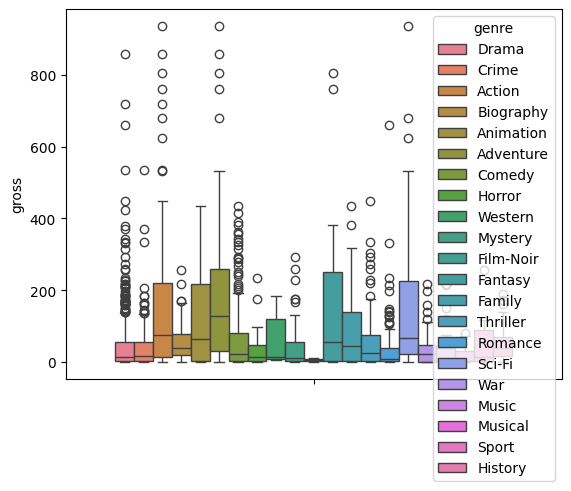

In [17]:
# Compute sum of gross collection per year and genre
movies2_long_sum_df = movies2_long_df.groupby(['year','genre']).sum()

sns.boxplot(y=movies2_long_df['gross'], hue=movies2_long_df['genre'])

[Text(0.5, 0, 'Year of Release'),
 Text(0, 0.5, 'Gross Collection in Millions'),
 Text(0.5, 1.0, 'Movie Trend Over the Years')]

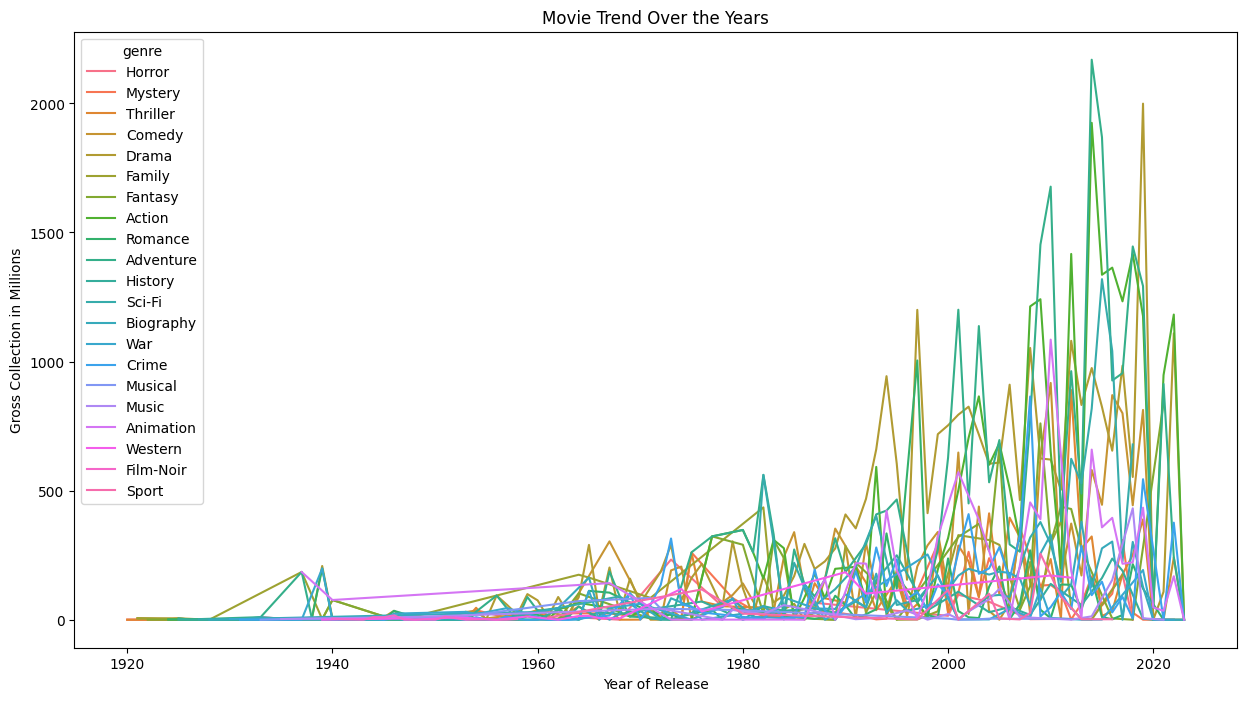

In [18]:
fig, ax = plt.subplots(figsize=(15, 8))
genre_trend = sns.lineplot(x='year', y='gross',hue='genre',
                           data=movies2_long_sum_df,ax=ax)
genre_trend.set(xlabel='Year of Release',ylabel='Gross Collection in Millions',
                 title='Movie Trend Over the Years')

# Movie Title

This analysis includes using the MovieLens 100k dataset as it contains more variables that can be used to model the suggested movie title based on the adjusted weighted rating formula.

To run the models, it is recommended to clear the resources and start fresh as this module using even just on CPU resources.


---


The model achieved a very good MSE of less than 0.01 and with an R-square coefficient of 0.80 when the model was tested on the sample test set.

In [1]:
import requests, zipfile, io
import gzip
import os

## MovieLens 100k dataset
movie_lens_url = 'https://files.grouplens.org/datasets/movielens/ml-latest.zip'

r = requests.get(movie_lens_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall('/content/movielens')

## Ratings from IMDB dataset
ratings = 'https://datasets.imdbws.com/title.ratings.tsv.gz'
!wget {ratings}a v

# Set chunk size
chunk_size = 4096

# Ratings
with gzip.open('title.ratings.tsv.gz', 'rb') as f_in:
  with open('ratings.txt', 'wb') as f_out:
    chunk = f_in.read(chunk_size)
    while chunk:
      f_out.write(chunk)
      chunk = f_in.read(chunk_size)

--2024-06-03 12:58:29--  https://datasets.imdbws.com/title.ratings.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 13.249.98.35, 13.249.98.91, 13.249.98.61, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|13.249.98.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7253752 (6.9M) [binary/octet-stream]
Saving to: ‘title.ratings.tsv.gz’

title.ratings.tsv.g 100%[===================>]   6.92M  41.9MB/s    in 0.2s    

2024-06-03 12:58:30 (41.9 MB/s) - ‘title.ratings.tsv.gz’ saved [7253752/7253752]



In [2]:
import pandas as pd

# Load basics dataset, remove 1st 2 char and convert tconst to int
ratings_df = pd.read_csv('ratings.txt', sep='\t')
ratings_df['tconst'] = ratings_df['tconst'].str.slice(2)
ratings_df['tconst'] = pd.to_numeric(ratings_df['tconst'])

In [3]:
## Load MovieLens datasets
# Genome Scores
genome_scores = pd.read_csv('/content/movielens/ml-latest/genome-scores.csv')

# Genome Tags
genome_tags = pd.read_csv('/content/movielens/ml-latest/genome-tags.csv')

# Links
links = pd.read_csv('/content/movielens/ml-latest/links.csv',
                    usecols=['movieId','imdbId'])
links.columns = ['movieId','tconst']

# Movies
movies = pd.read_csv('/content/movielens/ml-latest/movies.csv')

In [4]:
# Merge movies and links, filter only top 5 genres based on most profitable genre
df = pd.merge(movies, links, on='movieId')
top5_genres = ['Drama','Adventure','Action','Comedy','Sci-Fi']
df = df[df['genres'].str.contains('|'.join(top5_genres))]

# Merge df and ratings IMDB w/ number of votes
df = pd.merge(df, ratings_df, on='tconst')

In [5]:
# Merge df and genome_scores
genome = pd.merge(genome_tags, genome_scores, on='tagId')
genome = genome.pivot(index=['movieId'],columns='tag',values='relevance')

print(genome.info())
genome

<class 'pandas.core.frame.DataFrame'>
Index: 16376 entries, 1 to 288167
Columns: 1128 entries, 007 to zombies
dtypes: float64(1128)
memory usage: 141.1 MB
None


tag,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.03200,0.02225,0.07000,0.05900,0.12300,0.13100,0.06175,0.19550,0.26625,0.03300,...,0.04125,0.01550,0.03775,0.03500,0.11525,0.04350,0.04050,0.03300,0.07700,0.01825
2,0.03250,0.03200,0.04050,0.05100,0.10050,0.06350,0.19825,0.07525,0.09750,0.06325,...,0.04100,0.02025,0.01100,0.01875,0.13425,0.01850,0.01825,0.00825,0.08750,0.01375
3,0.04150,0.05525,0.02125,0.07225,0.05125,0.04400,0.03000,0.10375,0.02300,0.03250,...,0.06175,0.01825,0.02375,0.01700,0.12400,0.02775,0.01600,0.01325,0.10075,0.01800
4,0.03150,0.03400,0.02800,0.02725,0.06475,0.03325,0.02700,0.06900,0.03950,0.02525,...,0.06175,0.02350,0.01825,0.03075,0.17725,0.03950,0.01925,0.01100,0.10225,0.01375
5,0.03950,0.05200,0.02575,0.04475,0.07300,0.05375,0.02100,0.05050,0.01875,0.02225,...,0.05575,0.01750,0.01550,0.01650,0.17750,0.01975,0.01875,0.00900,0.09050,0.01475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286901,0.03425,0.03550,0.03975,0.02800,0.11725,0.06400,0.06875,0.11100,0.20500,0.02425,...,0.06475,0.02250,0.01750,0.03325,0.21375,0.05450,0.12725,0.01900,0.07625,0.01500
286905,0.07525,0.07800,0.12050,0.04250,0.20975,0.08500,0.10650,0.08650,0.08700,0.06800,...,0.05500,0.03225,0.04775,0.05700,0.20075,0.07150,0.03000,0.05550,0.09475,0.02375
287377,0.06250,0.05800,0.06575,0.12250,0.19625,0.10200,0.03300,0.17575,0.09800,0.03350,...,0.03850,0.03000,0.02050,0.05750,0.22900,0.04475,0.07900,0.00800,0.13250,0.03525


In [6]:
# Perform variable cleanup
del(genome_scores)
del(genome_tags)
del(links)
del(movies)
del(ratings_df)

In [7]:
# Finally, merge df and genome
df = pd.merge(df, genome, on='movieId')

# Delete unused variables
del(genome)

**Develop Model**

Random forest algorithm was used to determine which of the movie tags have the most influence in terms of the movie popularity based on number of votes.

As the number of votes is extremely skewed, in preparation for modeling using XGBoost, transformation using min-max scaling was used. This was also applied on the average rating as one of the many independent variables from the movie tags.

<Axes: ylabel='numVotes'>

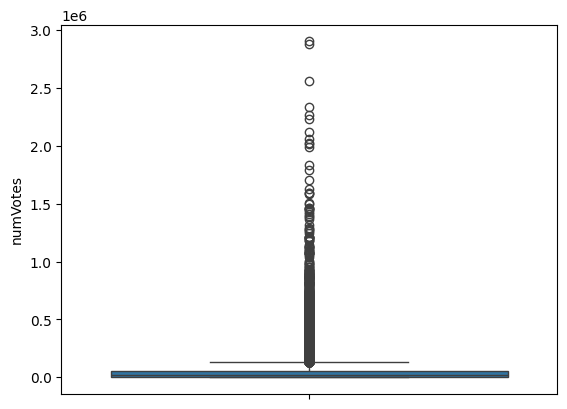

In [8]:
import matplotlib as plt
import seaborn as sns

# Does the number of votes follow normal distribution?
sns.boxplot(y=df['numVotes'])

In [9]:
# Delete unnecessary columns
del_cols = ['movieId','title','genres','tconst']
df = df.drop(del_cols, axis=1)

# Create array of numVotes as dependent variable
y = df['numVotes']

# Create dataframe of independent variables
x = df.drop('numVotes',axis=1)

In [10]:
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Create train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=100)

## Standardize using min-max scaler
min_max_scaler = preprocessing.MinMaxScaler()

#
x_train_averageRating = x_train['averageRating'].values.astype(float).reshape(-1,1)
train_scaled_array = min_max_scaler.fit_transform(x_train_averageRating)
x_train['averageRating'] = train_scaled_array

x_test_averageRating = x_test['averageRating'].values.astype(float).reshape(-1,1)
test_scaled_array = min_max_scaler.fit_transform(x_test_averageRating)
x_test['averageRating'] = test_scaled_array

y_train = y_train.values.astype(float).reshape(-1,1)
y_train = min_max_scaler.fit_transform(y_train)

y_test = y_test.values.astype(float).reshape(-1,1)
y_test = min_max_scaler.fit_transform(y_test)

In [29]:
from xgboost import XGBRegressor

# Train using XGBoost
model = XGBRegressor(seed=100)
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [30]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Predict with test dataset
predictions = model.predict(x_test)

# Calculate MSE and R2
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print('MSE: ', mse)
print('R2', r2)

MSE:  0.0008094726517447011
R2 0.7922950539318743


In [32]:
model_features = list(zip(model.feature_names_in_,model.feature_importances_))
model_features = pd.DataFrame(model_features,columns=['Features','Importance'])
model_features = model_features.sort_values(by=['Importance'], ascending=False)
print(model_features)

# Export to CSV
model_features.to_csv('Features Importance.csv')

                    Features  Importance
745                    oscar    0.102253
93                   awesome    0.100198
1016               teenagers    0.057613
743            original plot    0.037117
367                 exciting    0.036439
...                      ...         ...
1017                   teens    0.000000
1018           teleportation    0.000000
1066                  utopia    0.000000
1064  unusual plot structure    0.000000
148                     boat    0.000000

[1129 rows x 2 columns]
